In [1]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../g3m_utils/')
from state_evolution.data_models.custom import Custom,CustomSpectra
from state_evolution.experiments.learning_curve import CustomExperiment
import pandas as pd
from scipy.special import erf
from scipy.optimize import minimize_scalar
import pickle


In [2]:
from cycler import cycler
from matplotlib.pyplot import cm
double_plasma=[col for col in cm.plasma(np.linspace(0, 1, 5)) for _ in range(2)]
plt.rc('axes', prop_cycle=(cycler(color=cm.plasma(np.linspace(0, 1, 8)) )))

In [3]:
def door(x):
    return np.sign(x)*np.minimum(np.abs(x),2)*1.1

In [4]:
d=600
k=2400
kt=1200

In [5]:
Sigma=np.ones(d) #covariance matrix of data

In [6]:
def replica(alphas,Psi,Omega, Phi,theta,lamb=0.1,verbose=False):   
    
    data_model=Custom(
                     teacher_teacher_cov=Psi,
                     student_student_cov=Omega,
                     teacher_student_cov=Phi,
                     teacher=theta.flatten()*np.sqrt(kt),
                     fixed_teacher=True)

    
    experiment = CustomExperiment(task = 'ridge_regression', 
                                      regularisation = lamb, 
                                      data_model = data_model, 
                                      tolerance = 1e-9, 
                                      damping = 0.5, 
                                      verbose = verbose, 
                                      max_steps = 10000)
    
    experiment.learning_curve(alphas =[alphas[0]])
    replicas=experiment.get_curve()
    
    


    for i in range(1,len(alphas)):

        
        experiment = CustomExperiment(task = 'ridge_regression', 
                                  regularisation = lamb, 
                                  data_model = data_model, 
                                  tolerance = 1e-9, 
                                  damping = 0.5, 
                                  verbose = verbose, 
                                  max_steps = 10000)
        experiment.learning_curve(alphas =[alphas[i]])
        replicas=pd.concat([replicas,experiment.get_curve()])

    
    return replicas

In [7]:
activ="door"

g1=lambda x: door(x)

r_1=np.mean(Sigma)
k1=quad(lambda x: np.exp(-.5*x**2/r_1)*x*g1(x)/np.sqrt(2*np.pi*r_1),-np.inf,np.inf)[0]/r_1
norm=quad(lambda x: np.exp(-.5*x**2/r_1)*g1(x)**2/np.sqrt(2*np.pi*r_1),-np.inf,np.inf)[0]


f1=lambda x: g1(x)




In [8]:
np.random.seed(42)
theta=np.random.randn(kt)/np.sqrt(kt)
Wt=np.random.randn(kt,d)/np.sqrt(d)

Ws=[np.random.randn(k,d)/np.sqrt(d)]
for i in range(9):
    Ws.append(np.random.randn(k,k)/np.sqrt(k))

In [9]:
teacher_activ="sign"

ft=lambda x:  np.sign(x)

rt=np.mean(Sigma)

k1_t=quad(lambda x: np.exp(-.5*x**2/rt)*x*ft(x)/np.sqrt(2*np.pi*rt),-np.inf,np.inf)[0]/rt
var_t=quad(lambda x: np.exp(-.5*x**2/rt)*ft(x)**2/np.sqrt(2*np.pi*rt),-np.inf,np.inf)[0]
ks_t=np.sqrt(np.maximum(var_t-rt*k1_t**2,0))


Psi=k1_t**2*Wt@np.diag(Sigma)@Wt.T+ks_t**2*np.eye(kt)


In [10]:
max_layer=6
r=np.mean(Sigma)

lamb=0.001

alphas=np.linspace(0.1,8,150)

Omega=(np.diag(Sigma)).copy()
Phi=(k1_t*np.diag(Sigma)@Wt.T).copy()

errors={}



for L in range(1,max_layer+1,1):
    print("Computing error at layer L=",L)
    
    k1=quad(lambda x: np.exp(-.5*x**2/r)*x*f1(x)/np.sqrt(2*np.pi*r),-np.inf,np.inf)[0]/r
    var=quad(lambda x: np.exp(-.5*x**2/r)*f1(x)**2/np.sqrt(2*np.pi*r),-np.inf,np.inf)[0]
    ks=np.sqrt(np.abs(var-r*k1**2))
  
    
    r=var

    W=Ws[L-1]
    
    Omega=(k1**2* W@Omega@W.T+ks**2*np.eye(k)).copy()
    
    Phi=(W@Phi*k1).copy()
    
 
    
    errors[L]=replica(alphas*d/k,Psi,Omega, Phi,theta,lamb=0.001)["test_error"]
    
    
    
    




Computing error at layer L= 1
Computing error at layer L= 2
Computing error at layer L= 3
Computing error at layer L= 4
Computing error at layer L= 5
Computing error at layer L= 6


Text(0, 0.5, '$\\epsilon_g$')

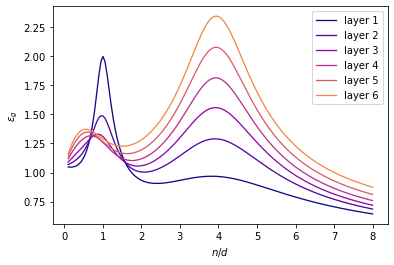

In [11]:
for L in errors.keys():
    plt.plot(alphas, errors[L],label="layer "+str(L),linewidth=1.3)

plt.legend()
plt.xlabel(r"$n/d$")
plt.ylabel(r"$\epsilon_g$")


In [36]:
def ridge_estimator(X, y, lamb=0.1):    #ridge regression
    m, n = X.shape
    
    if m >= n:
        return np.linalg.inv(X.T @ X + lamb*np.identity(n)) @ X.T @ y
    elif m < n:
        return X.T @ np.linalg.inv(X @ X.T+ lamb*np.identity(m)) @ y



def generate_samples(L,sample_complexity,seed):   #generating the samples
    np.random.seed(seed)
    n = int(d*sample_complexity)
    C = np.random.normal(0,1, (n,d))
    X=C.T.copy()
    
    for i in range(L):
        X=f1(Ws[i]@X)
    X=X.T
    return C, X    #C is the input, X is the last layer post-activation

def get_instance(L,sample_complexity, seed):
    C, X = generate_samples(L,sample_complexity,seed)
    y = (theta@ft(Wt@C.T)).flatten()  #labels
    
    return X,y


def get_error(L,alphas,verbose=False):
    Eg=None
    #compute for all the desired sample complexities
    for alpha in alphas:
        if verbose: print("Computing sample complexity alpha=",alpha)
        sample_complexity=alpha
        eg=[]

        # Average over seeds
        for j in range(10):

            V_train, y_train = get_instance(L,sample_complexity,seed=j*756)
            V_test, y_test = get_instance(L,max(sample_complexity,2),seed=j+1234)

            w = ridge_estimator(V_train/np.sqrt(V_train.shape[1]), y_train, lamb=lamb)

            yhat_test =( V_test/np.sqrt(V_train.shape[1]) @ w )
            test_error  = np.mean((yhat_test - y_test)**2)

            eg.append(test_error)
        if alpha==alphas[0]:
            Eg=np.array(eg)
        else:
            Eg=np.vstack((Eg,np.array(eg)))
        
        

    return Eg


In [37]:
alphas_simu=np.linspace(.1,5,8)
Simus=get_error(L=3,alphas=alphas_simu,verbose=True)
#to repeat for every layer L

Computing sample complexity alpha= 0.1
Computing sample complexity alpha= 0.8
Computing sample complexity alpha= 1.5000000000000002
Computing sample complexity alpha= 2.2
Computing sample complexity alpha= 2.9000000000000004
Computing sample complexity alpha= 3.6000000000000005
Computing sample complexity alpha= 4.3
Computing sample complexity alpha= 5.0


Text(0, 0.5, '$\\epsilon_g$')

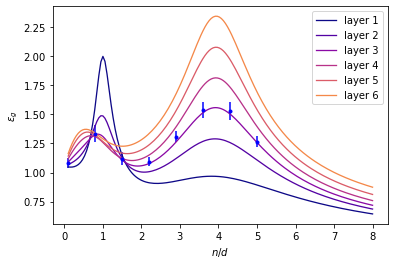

In [38]:
for L in errors.keys():
    plt.plot(alphas, errors[L],label="layer "+str(L),linewidth=1.3)
plt.errorbar(alphas_simu,Simus.mean(1),Simus.std(1),ls="",marker=".",color="blue")
plt.legend()
plt.xlabel(r"$n/d$")
plt.ylabel(r"$\epsilon_g$")